# Exercises & Extra-curriculum

In [1]:
import torch
import torchvision
print(f"Torch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

dev = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {dev}")

Torch version: 1.13.1+cu117
Torchvision version: 0.14.1+cu117
Device: cuda


In [2]:
# Getting the model 
model = torch.load(f="./models/transfer_learning_model.pth", map_location="cuda")
next(iter(model.parameters())).device, model.state_dict

(device(type='cuda', index=0),
 <bound method Module.state_dict of EfficientNet(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): SiLU(inplace=True)
     )
     (1): Sequential(
       (0): MBConv(
         (block): Sequential(
           (0): Conv2dNormActivation(
             (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
             (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (2): SiLU(inplace=True)
           )
           (1): SqueezeExcitation(
             (avgpool): AdaptiveAvgPool2d(output_size=1)
             (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
             (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
             (activation): SiLU(inplace=True)


### **1.** Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. Check out 03. PyTorch Computer Vision section 10 for ideas.

In [3]:
# 1. Get the test data
from pathlib import Path
from going_modular.going_modular import data_setup
from torchvision import transforms

# Data dirs
train_dir = "./.data/pizza_steak_sushi/train"
test_dir = "./.data/pizza_steak_sushi/test"

# Auto transform
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transform = weights.transforms()

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                              test_dir=test_dir,
                              transform=auto_transform,
                              batch_size=32)
test_dataloader, len(test_dataloader)

(<torch.utils.data.dataloader.DataLoader at 0x7b205e7a8f40>, 3)

In [4]:
# 2. Make the predictions 
y_true = torch.Tensor([]).to(dev)
y_pred = torch.Tensor([]).to(dev)
y_probs = torch.Tensor([]).to(dev)
images = torch.Tensor([]).to(dev)

with torch.inference_mode():
    model.eval()
    
    for batch, (batch_X,batch_y) in enumerate(test_dataloader):
        batch_X, batch_y = batch_X.to(dev), batch_y.to(dev)
        
        # Inference
        batch_logits = model(batch_X)
        batch_probs = torch.amax(torch.softmax(batch_logits, dim=1), dim=1)
        batch_y_pred = torch.argmax(batch_logits, dim=1)
        
        # Store results
        y_true = torch.cat((y_true, batch_y), dim=0)
        y_pred = torch.cat((y_pred, batch_y_pred), dim=0)
        y_probs = torch.cat((y_probs, batch_probs),dim=0)
        images = torch.cat((images, batch_X), dim=0)
        

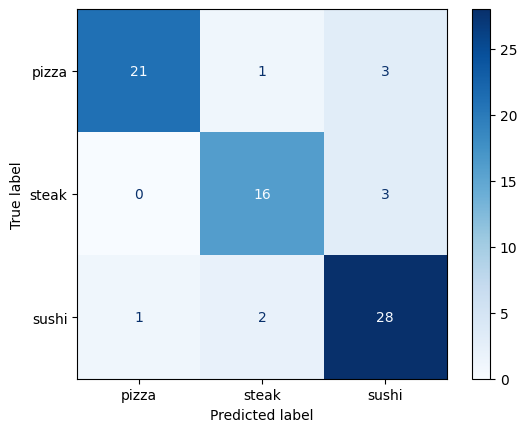

In [5]:
# 3. Plot the confusion matrix 
import matplotlib.pyplot as plt 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

conf_m = confusion_matrix(y_true=y_true.cpu(),
                          y_pred=y_pred.cpu(),
                          labels=range(len(class_names)))
disp = ConfusionMatrixDisplay(conf_m, display_labels=class_names)
disp.plot(cmap="Blues")
plt.show()

### **2.** Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by wrong prediction and then descending predicted probabilities, this will give you the wrong predictions with the highest prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

In [21]:
# Getting the lowest probs gotten in the prediction
# First we get a vector with the false predictions 
wrong_preds = (y_pred!=y_true)
# Now we add the probabilitie associated to the prediction
preds_and_probs = [[int(wrong_preds[idx].item()), y_probs[idx].item(), images[idx], y_pred[idx], y_true[idx]] for idx in range(len(y_pred))]

# Finally we sort first by wrong prediction and secondly by probabilitie 
# Idea: getting the wrong predictions with higher probs, which means the worst predictions 
preds_and_probs_sorted = sorted(preds_and_probs, key= lambda x: (-x[0], -x[1]))
worst_preds_top5 = preds_and_probs_sorted[0:5]
print(f"Wrong predictions with the highest probs (top 5):")
for i in range(5):
    print("|",worst_preds_top5[i][0],"--",worst_preds_top5[i][1],"|")

Wrong predictions with the highest probs (top 5):
| 1 -- 0.5609512329101562 |
| 1 -- 0.5085580945014954 |
| 1 -- 0.4880623519420624 |
| 1 -- 0.4722236394882202 |
| 1 -- 0.4319792091846466 |


In [22]:
def inverse_transform(img: torch.Tensor) -> torch.Tensor:
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0) * std + mean
    img = torch.clamp(img, 0, 1)
    return img

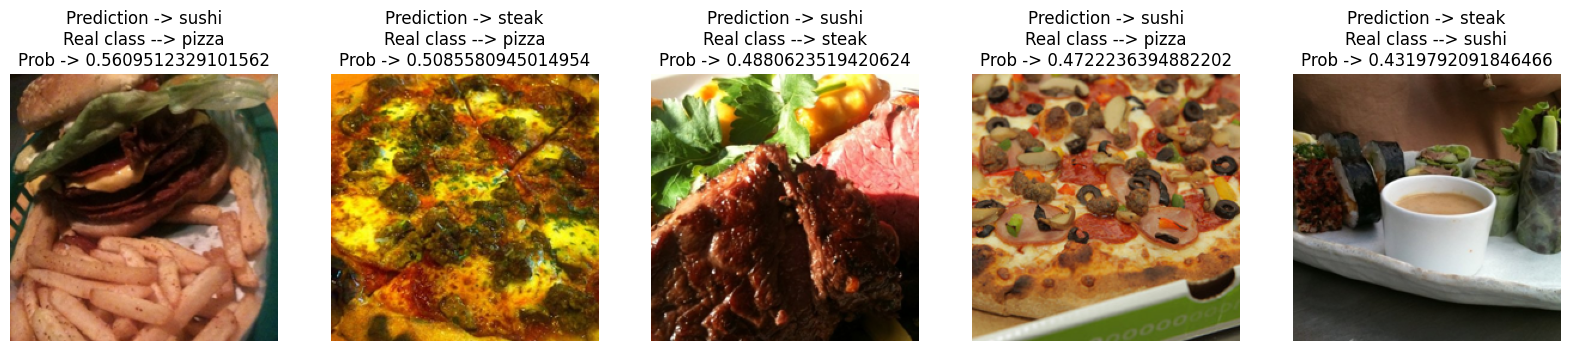

In [23]:
fig = plt.figure(figsize=(20, 9))
for idx, (wrong_pred, prob, img, pred, true_label) in enumerate(worst_preds_top5):
    fig.add_subplot(1, 5, idx+1)
    plt.imshow(inverse_transform(img.cpu()))
    plt.title(f"Prediction -> {class_names[int(pred)]}\nReal class --> {class_names[int(true_label)]}\nProb -> {prob}")
    plt.axis(False)
plt.show()

In general, I can undestand why the model get confused in this images, especially the first one, which is an image of a burger labeled as a pizza (i wonder why, haha). The only one where the model's confusion is a bit strange is the fourth one from the left, because it's clearly a pizza. I guess when the photo it's too zoomed in, the model might get confused since it loses the edges of the objeto (in this case, the circular perimeter).

### **3.** Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

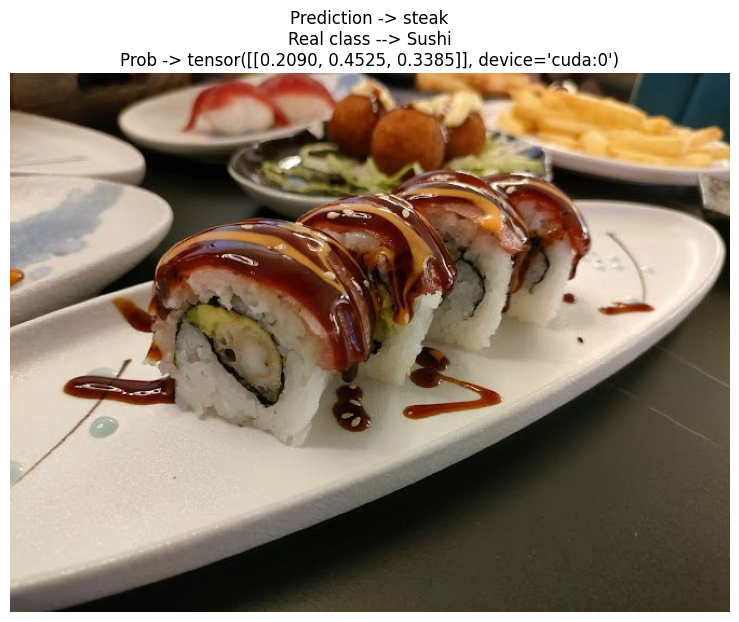

In [33]:
# Predicting my own custom image (i'll use the same from the 06_notebook)with torch.inference_mode():
from PIL import Image

pil_image = Image.open("./.data/custom_image.jpg")
image = auto_transform(pil_image)
with torch.inference_mode():
    model.eval()
    logits = model(image.unsqueeze(dim=0).cuda())
    prob = torch.softmax(logits, dim=1)
    pred = torch.argmax(logits, dim=1)
    
plt.figure(figsize=(15, 7))
plt.imshow(pil_image)
plt.title(f"Prediction -> {class_names[int(pred)]}\nReal class --> Sushi\nProb -> {prob}")
plt.axis(False)
plt.show()

Sadly, the model got my custom image prediction wrong. Maybe it's because sushi is the class with the most variations, so it's harder to predict correctly. Also, this sushi has a sauce on top whose color is quite similiar to that of steak.

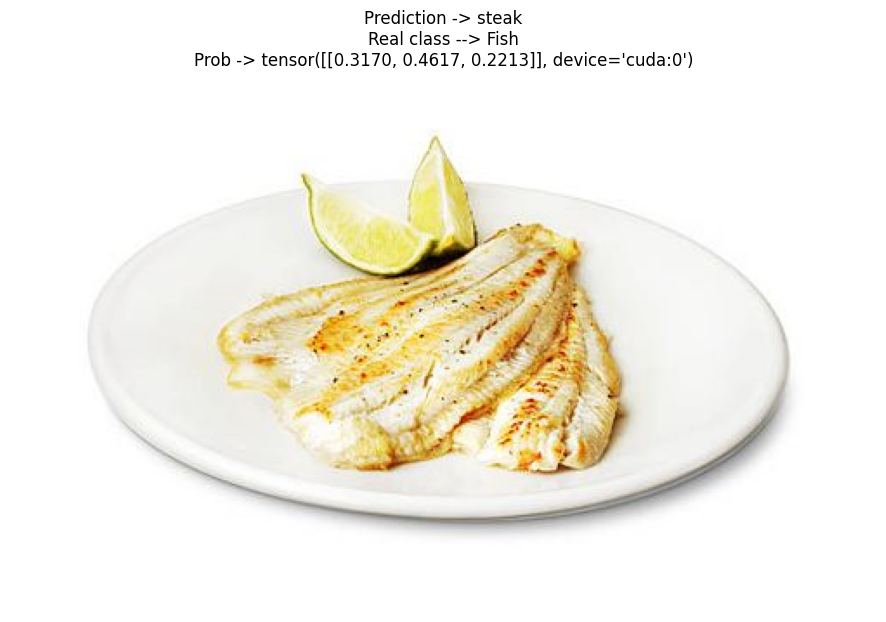

In [38]:
# Trying in a random image that can be similiar to a pizza 

# Getting the new image
import requests as rq
data_path = Path(".data")
custom_image_path = data_path/"custom_image_2.jpg"
if not custom_image_path.exists():
    print(f"Downloading image at: '{custom_image_path}'...")
    url = "https://imgs.search.brave.com/T2EqpQwBr6DKkcml8zmkE1ZE-L20tZhU4sLSxPfGyqQ/rs:fit:500:0:1:0/g:ce/aHR0cHM6Ly9tZWRp/YS5nZXR0eWltYWdl/cy5jb20vaWQvMTgy/ODAwNTQ0L2VzL2Zv/dG8vcGxhdGlqYS1m/aWxldGVzLWxhcmdv/cy5qcGc_cz02MTJ4/NjEyJnc9MCZrPTIw/JmM9Q09JTXRna0ow/NVdrdUE3V3BRTldf/YUV0Z0dobV9MWEt1/OHN0VVNqTFM0VT0"
    request = rq.get(url=url)
    with custom_image_path.open("wb") as f:
        f.write(request.content)
        
# Making the inference
pil_image = Image.open("./.data/custom_image_2.jpg")
image = auto_transform(pil_image)
with torch.inference_mode():
    model.eval()
    logits = model(image.unsqueeze(dim=0).cuda())
    prob = torch.softmax(logits, dim=1)
    pred = torch.argmax(logits, dim=1)

# Plot 
plt.figure(figsize=(15, 7))
plt.imshow(pil_image)
plt.title(f"Prediction -> {class_names[int(pred)]}\nReal class --> Fish\nProb -> {prob}")
plt.axis(False)
plt.show()

As I expected, due to the similarity in shape and appearance between a steak and fish, the model predicted fish. 

### **4.** Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?

In [ ]:
# Getting the model again 
from going_modular.going_modular import engine 
import torchinfo

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(dev)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=3,
                    bias=True)
)
torchinfo.summary(model=model,
                  input_size=(1, 3, 224, 224),
                  device=dev,
                  row_settings=["var_names"])

Layer (type (var_name))                                      Output Shape              Param #
EfficientNet (EfficientNet)                                  [1, 3]                    --
├─Sequential (features)                                      [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation (0)                              [1, 32, 112, 112]         --
│    │    └─Conv2d (0)                                       [1, 32, 112, 112]         864
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         64
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         --
│    └─Sequential (1)                                        [1, 16, 112, 112]         --
│    │    └─MBConv (0)                                       [1, 16, 112, 112]         1,448
│    └─Sequential (2)                                        [1, 24, 56, 56]           --
│    │    └─MBConv (0)                                       [1, 24, 56, 56]           6,00

In [57]:
# Training for 10 epochs this time 
optim = torch.optim.Adam(params=model.parameters(),
                         lr=0.0005)
loss = torch.nn.CrossEntropyLoss()

print(f"------------ Training for 10 epochs ------------")
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optim,
                       loss_fn=loss,
                       device=dev,
                       epochs=10)

------------ Training for 10 epochs ------------


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1872 | train_acc: 0.8750 | test_loss: 0.3998 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.2262 | train_acc: 0.8672 | test_loss: 0.1478 | test_acc: 0.9792
Epoch: 3 | train_loss: 0.2048 | train_acc: 0.8750 | test_loss: 0.1491 | test_acc: 0.9583
Epoch: 4 | train_loss: 0.2168 | train_acc: 0.8633 | test_loss: 0.1117 | test_acc: 0.9792
Epoch: 5 | train_loss: 0.1346 | train_acc: 0.8672 | test_loss: 0.1065 | test_acc: 0.9792
Epoch: 6 | train_loss: 0.0571 | train_acc: 1.0000 | test_loss: 0.1045 | test_acc: 0.9792
Epoch: 7 | train_loss: 0.0415 | train_acc: 1.0000 | test_loss: 0.1069 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.3854 | train_acc: 0.8750 | test_loss: 0.1162 | test_acc: 0.9792
Epoch: 9 | train_loss: 0.3740 | train_acc: 0.8750 | test_loss: 0.1608 | test_acc: 0.9479
Epoch: 10 | train_loss: 0.1172 | train_acc: 0.9883 | test_loss: 0.1632 | test_acc: 0.9479


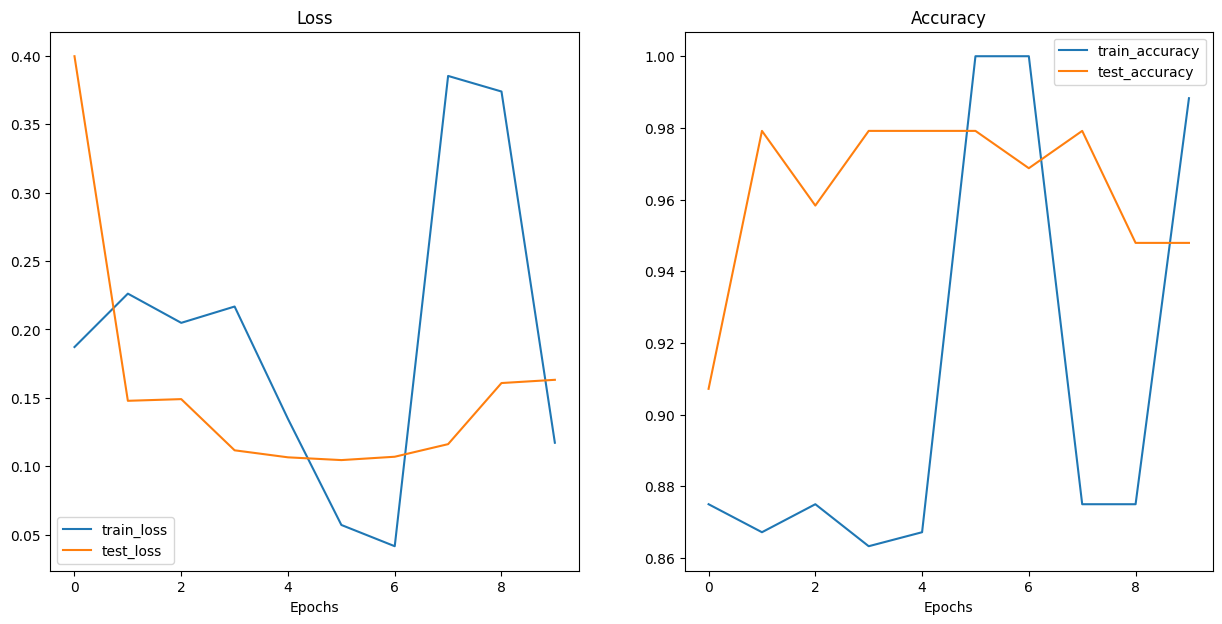

In [58]:
# Visualize 
import helper_functions 
helper_functions.plot_loss_curves(results=results)

The performances gets a bit better, maybe using even more epochs it might go even higher (and, more imporant, stable).

### **5.** Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the 20% Pizza, Steak, Sushi dataset on the course GitHub. It was created with the notebook extras/04_custom_data_creation.ipynb.

### **6.** Try a different model from torchvision.models on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps torchvision.models.efficientnet_b2()?